In [18]:
pwd

'/data2/mito_lineage/Analysis/peaks_expression/2020_11_18'

In [2]:
config_f = "config.yaml"

In [3]:
from src.utils.parse_config import read_config_file
from os.path import join, dirname
import pandas as pd
from glob import glob
config = read_config_file(config_f)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


### Load:
1. Raw cells barcode w qc info
2. filtered cells barcode list
3. Peak-by-cell sparse matrix
4. Peak gene annotations 
5. Graph clustering filtered cells cluster label
6. TF-by-cell sparse count matrix
7. TF labels

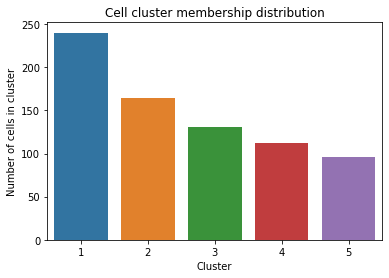

In [4]:
curr_in = join(config["indir"], config['samples'][0], 'outs')

### Create 1-based cell barcode index 

cells = pd.read_csv(join(curr_in,"singlecell.csv"))
cells

good_cells = cells[~(cells["cell_id"]=="None")].copy()
good_cells["ID"] = np.arange(1,len(good_cells)+1)
good_cells

cell_inds = pd.read_csv(join(curr_in, "filtered_peak_bc_matrix","barcodes.tsv"),header=None)
cell_inds

## Load peak annotations

peak_annotations = pd.read_csv(join(config["indir"], config['samples'][0], 'outs','peak_annotation.tsv'),sep='\t')
peak_annotations


### Load clusters

cluster_f = glob(join(config["indir"], config['samples'][0], 'outs','analysis',"clustering", "graphclust","clusters.csv"))
clusters_df = pd.read_csv(cluster_f[0])
clusters_df

%matplotlib inline
sns.countplot(clusters_df["Cluster"])
plt.title("Cell cluster membership distribution")
plt.ylabel("Number of cells in cluster")
plt.xlabel("Cluster")
## Load peaks matrix

filename = join(config['indir'],config['samples'][0],'outs','filtered_peak_bc_matrix/matrix.mtx')
peaks_sparse_mtx = pd.read_csv(filename,sep=' ',skiprows=2, header=None).iloc[1:]
peaks_sparse_mtx.columns = ["Peak", "Cell", "Count"]

In [39]:
cell_inds

,0
0,AAACGAAGTGTCCCAG-1
1,AAACTGCGTAGCGTTT-1
2,AAAGATGAGTCCGGAA-1
3,AAAGATGCAGGGCTTC-1
4,AAAGATGCATGTGGGA-1
...,...
738,TTTGAGGGTTTGTAGC-1
739,TTTGCGCCAACTCGAT-1
740,TTTGGCCCACCGAAAG-1
741,TTTGGTTTCTACATCT-1


In [5]:
clusters_df.head()

,Barcode,Cluster
0,AAACGAAGTGTCCCAG-1,1
1,AAACTGCGTAGCGTTT-1,2
2,AAAGATGAGTCCGGAA-1,1
3,AAAGATGCAGGGCTTC-1,2
4,AAAGATGCATGTGGGA-1,2


In [6]:
peaks_sparse_mtx

,Peak,Cell,Count
1,65796,1,2
2,65765,1,2
3,65672,1,2
4,65649,1,4
5,65425,1,1
...,...,...,...
2076830,49,743,2
2076831,47,743,2
2076832,46,743,4
2076833,16,743,4


# Annotate peak count matrix with gene name

In [7]:
peaks_sparse_mtx["Cluster"] = peaks_sparse_mtx["Cell"].apply(lambda x: clusters_df.loc[x-1,"Cluster"])
peaks_sparse_mtx

,Peak,Cell,Count,Cluster
1,65796,1,2,1
2,65765,1,2,1
3,65672,1,2,1
4,65649,1,4,1
5,65425,1,1,1
...,...,...,...,...
2076830,49,743,2,1
2076831,47,743,2,1
2076832,46,743,4,1
2076833,16,743,4,1


In [8]:
peaks_sparse_mtx["gene"] = peaks_sparse_mtx["Peak"].apply(lambda x: peak_annotations.loc[x-1,"gene"])

In [9]:
peaks_sparse_mtx

,Peak,Cell,Count,Cluster,gene
1,65796,1,2,1,VAMP7
2,65765,1,2,1,LAGE3
3,65672,1,2,1,CXorf40B
4,65649,1,4,1,AFF2
5,65425,1,1,1,SASH3;XPNPEP2
...,...,...,...,...,...
2076830,49,743,2,1,SLC35E2B
2076831,47,743,2,1,MIB2;MMP23B
2076832,46,743,4,1,MIB2
2076833,16,743,4,1,AGRN


## See the number of cells within a peak and number of peaks within a cell.

In [29]:
peaks_dense = peaks_sparse_mtx.pivot(index="Peak", columns="Cell",values="Count").fillna(0)
print((peaks_dense>0).sum())

Cell
1      1692
2      4168
3       973
4      1020
5      1256
       ... 
739    2691
740      58
741    1829
742      72
743    3395
Length: 743, dtype: int64


Text(0.5, 1.0, 'Distribution of number of peaks seen in a cell across all cells')

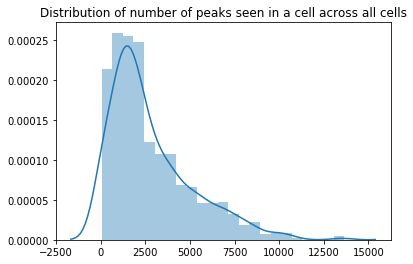

In [30]:
sns.distplot((peaks_dense>0).sum(axis=0))
plt.title("Distribution of number of peaks seen in a cell across all cells")

Text(0.5, 1.0, 'Distribution of the number of cells seen in a peak across all peaks')

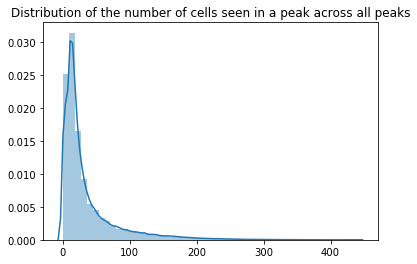

In [31]:
sns.distplot((peaks_dense>0).sum(axis=1))
plt.title("Distribution of the number of cells seen in a peak across all peaks")

## Look at CHIP mutations
- TP53
- U2AF1
- SF3B1
- SRSF2
- TET2
- IDH1
- IDH2  
TP53 and the splicing factor U2AF1 conferred the highest risk of AML development with hazard ratios of 12.5 and 7.9, respectively.16 This contrasts with hazard ratios for DNMT3A and TET2 of 1.4 and 1.6, respectively. In the study by Desai et al, mutations of TP53 and spliceosome genes (U2AF1, SF3B1,or SRSF2) also conferred a higher risk of AML development, with odds ratios of 47.2 and 7.4, respectively.17
They also identified IDH1, IDH2, and RUNX1 with PHF6 mutations as high-risk mutations. Re- markably, in this study, all persons with TP53 mutations (n 5 21) or IDH1/2 mutations (n 5 15) developed AML a median of 5 to 6 years from CH sampling.

In [32]:
chip_genes = ["TP53", "U2AF1", "SF3B1", "SRSF2", "TET2", "IDH1", "IDH2"]

In [33]:
chip_df = peak_annotations[peak_annotations["gene"].isin(chip_genes)]
chip_inds = peak_annotations[peak_annotations["gene"].isin(chip_genes)].index
chip_df["ID"] = chip_df.apply(lambda x: x["gene"]+"_"+x["peak_type"]+"_"+x["distance"],axis=1)
chip_df

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,peak,gene,distance,peak_type,ID
10916,chr2_197434412_197435520,SF3B1,0,promoter,SF3B1_promoter_0
10917,chr2_197442667_197442850,SF3B1,-7577,distal,SF3B1_distal_-7577
11221,chr2_208254235_208255725,IDH1,0,promoter,IDH1_promoter_0
18383,chr4_104966594_104967100,TET2,-178775,distal,TET2_distal_-178775
18384,chr4_105057347_105058186,TET2,-87689,distal,TET2_distal_-87689
18385,chr4_105059241_105059853,TET2,-86022,distal,TET2_distal_-86022
18386,chr4_105060452_105061719,TET2,-84156,distal,TET2_distal_-84156
18387,chr4_105113744_105114295,TET2,-31580,distal,TET2_distal_-31580
18388,chr4_105135914_105136130,TET2,-9745,distal,TET2_distal_-9745
18389,chr4_105137189_105137898,TET2,-7977,distal,TET2_distal_-7977


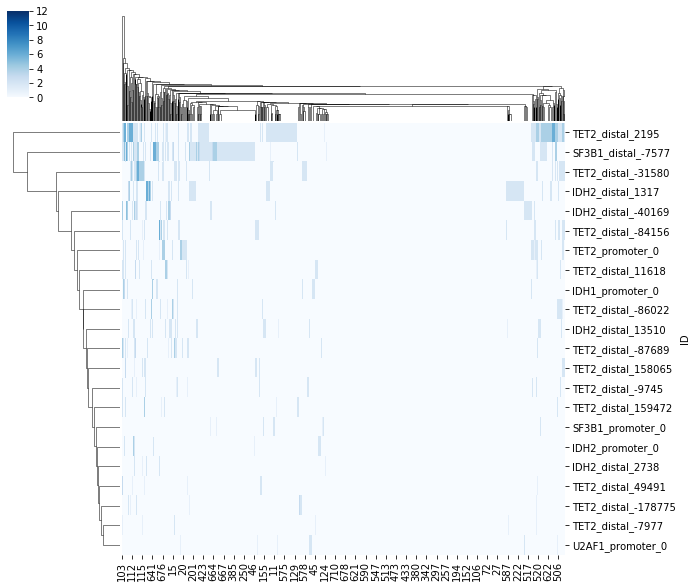

In [38]:
sns.clustermap(pd.merge(peaks_dense, chip_df[["ID"]], left_index=True, right_index=True).set_index("ID"), 
               cmap="Blues", vmax=12)

## Look at how many T-cell annotated peaks (gene TRAC) were there and how many cells contained it

In [12]:
peak_annotations[peak_annotations["gene"] == "TRAC"]


,peak,gene,distance,peak_type
48329,chr14_22555471_22557563,TRAC,7966,distal
48330,chr14_22560970_22562388,TRAC,13465,distal


In [13]:
trac_peaks = peaks_sparse_mtx[peaks_sparse_mtx["gene"] == "TRAC"].groupby(["Peak", "Cell"]).size().reset_index().rename({0:"Count"},axis=1)

In [14]:
print("Number of cells for each peaks")
trac_peaks.groupby("Peak").size()

Number of cells for each peaks


Peak
48330    128
48331     84
dtype: int64

In [15]:
print("Number of cells with at least one peak")
print(trac_peaks.groupby("Peak").size())
print("\n")
print("Number Cells with at least one peak annotated as TRAC:")
print((trac_peaks.pivot("Cell", columns="Peak").fillna(0)>0).any(axis=1).sum())

Number of cells with at least one peak
Peak
48330    128
48331     84
dtype: int64


Number Cells with at least one peak annotated as TRAC:
181


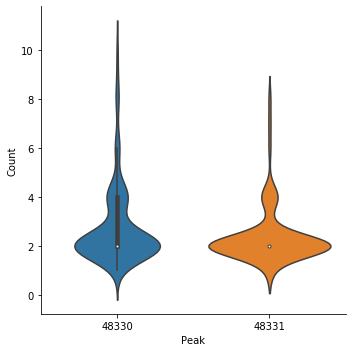

In [16]:
sns.catplot(data=peaks_sparse_mtx[peaks_sparse_mtx["gene"] == "TRAC"], x="Peak", y="Count", kind="violin")

### Conclusion: 
128+84 T-cell alpha receptor peaks were seen. They all have count of 1.

In [17]:
labels=trac_peaks["Peak"].unique()
joypy.joyplot(trac_peaks, by="Peak", column="Count", labels=labels, range_style='own',
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Peak counts across cells",
                          colormap=cm.autumn_r)

NameError: name 'joypy' is not defined

In [ ]:
sns.distplot(trac_peaks["Count"])

In [ ]:
#sns.heatmap(peaks_dense)

## Look at the peak count distribution for non-zero values (since that's too sparse)

In [ ]:
plt.hist(np.log10(peaks_sparse_mtx["Count"]))
plt.title("Log10 Count")

In [ ]:
import matplotlib.pyplot as plt
plt.hist((peaks_sparse_mtx["Count"]))
plt.title("All Peaks-Cells Count distribution")
plt.yscale("log")
plt.ylabel("Log frequency")
plt.xlabel("Count")

## Two peak-cell elements have greater than 200

In [ ]:
peaks_sparse_mtx[peaks_sparse_mtx["Count"]>200]["Count"]

In [ ]:
plt.hist(np.log10(peaks_sparse_mtx[peaks_sparse_mtx["Count"]>10]["Count"]))
plt.title("Log 10 for counts over 10")

In [ ]:
peaks_dense = peaks_sparse_mtx.iloc[1:].pivot(index="Peak", columns="Cell",values="Count").fillna(0)
peaks_dense

# Peak distribution values
### Make peak as categorical. 
### Break the count distribution into 3 for the peaks with counts, and add 0 as the other.
### Played with this b/c many are the same value and cant break it up easily.
### Had to make 6 bins but it picks up 3

In [ ]:
q_df, bins = pd.qcut((peaks_sparse_mtx["Count"]), 20, labels=np.arange(1,4), duplicates='drop', retbins=True)
peaks_sparse_mtx["Bin Peak"] = q_df
peaks_sparse_mtx["Bin Peak"] = peaks_sparse_mtx["Bin Peak"].astype(int)

In [ ]:
sns.countplot(peaks_sparse_mtx["Bin Peak"])

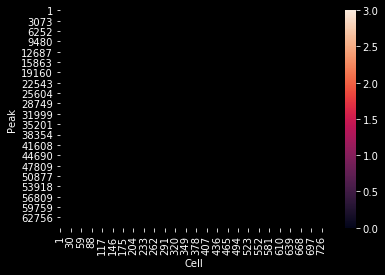

In [102]:
# plt.style.use('dark_background')
# sns.heatmap(peaks_sparse_mtx.pivot(index="Peak", columns="Cell",values="Bin Peak").fillna(0)) #.astype(int)#.fillna(0)

In [87]:
peak_cat = peaks_sparse_mtx.groupby(["Peak","Bin Peak"]).size().reset_index()

g = sns.catplot(x="Peak", y=0, hue="Bin Peak",
               data=peak_cat, kind="violin")

KeyboardInterrupt: 

In [10]:
import joypy
from matplotlib import cm


#labels=[y if y%10==0 else None for y in list(temp.Year.unique())]"n,
labels = peaks_sparse_mtx["Peak"].unique()
#AF_joy["log AF"] = np.log10(AF_joy["AF"]+1)
fig, axes = joypy.joyplot(peaks_sparse_mtx, by="Peak", column="Count", labels=labels, range_style='own',
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Peak counts across cells",
                          colormap=cm.autumn_r)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-18a6b85189b8>", line 11, in <module>
    colormap=cm.autumn_r)
  File "/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/joypy/joyplot.py", line 177, in joyplot
    converted, _labels, sublabels = _grouped_df_to_standard(grouped, column)
  File "/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/joypy/joyplot.py", line 153, in _grouped_df_to_standard
    group = group[column]
  File "/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/pandas/core/frame.py", line 3001, in __getitem__
    indexer = self.loc._convert_to_indexer(key, axis=1, raise_missing=True)
  File "/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/pandas/cor

KeyboardInterrupt: 